In [1]:
%set_env CUDA_DEVICE_ORDER=PCI_BUS_ID
%set_env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline
from config import domainData
from config import num_classes as NUM_CLASSES
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import utils
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
from localresponsenorm import LocalResponseNorm
from sklearn.metrics import confusion_matrix

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


```
net = models.alexnet(pretrained=True)
net.classifier = nn.Sequential(*list(net.classifier.children())[:-1])
# print(net)
```

In [3]:
class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input

class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))
    
alexnet = nn.Sequential( # Sequential,
    nn.Conv2d(3,96,(11, 11),(4, 4)),
    nn.
    nn.ReLU(inplace=True),
#     LocalResponseNorm(5, 0.0001, 0.75, 1),
    nn.MaxPool2d((3, 3),(2, 2),(0, 0),ceil_mode=True),
    nn.Conv2d(96,256,(5, 5),(1, 1),(2, 2),1,2),
    nn.ReLU(inplace=True),
#     LocalResponseNorm(5, 0.0001, 0.75, 1),
    nn.MaxPool2d((3, 3),(2, 2),(0, 0),ceil_mode=True),
    nn.Conv2d(256,384,(3, 3),(1, 1),(1, 1)),
    nn.ReLU(inplace=True),
    nn.Conv2d(384,384,(3, 3),(1, 1),(1, 1),1,2),
    nn.ReLU(inplace=True),
    nn.Conv2d(384,256,(3, 3),(1, 1),(1, 1),1,2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d((3, 3),(2, 2),(0, 0),ceil_mode=True),
    Lambda(lambda x: x.view(x.size(0),-1)), # View,
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(9216,4096)), # Linear,
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,4096)), # Linear,
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Sequential(Lambda(lambda x: x.view(1,-1) if 1==len(x.size()) else x ),nn.Linear(4096,1000)), # Linear,
    nn.Softmax(),
)

In [4]:
net = alexnet
net.load_state_dict(torch.load('alexnet.pth'))
# print(net)

In [5]:
net = nn.Sequential(*list(net.children())[:-2])
print(net)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU(inplace)
  (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (5): ReLU(inplace)
  (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1)
  (7): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (11): ReLU(inplace)
  (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (13): ReLU(inplace)
  (14): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  (15): Lambda(
  )
  (16): Sequential(
    (0): Lambda(
    )
    (1): Linear(in_features=9216, out_features=4096, bias

In [8]:
a = torch.Tensor(1,3,227,227).uniform_(0,255)

In [9]:
b = net(Variable(a))

In [5]:
src = domainData['amazon']
tar = domainData['webcam']

In [6]:
tmp_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(227, scale=(0.50,1.0), ratio=(1.,1.)),
    transforms.RandomHorizontalFlip()
])
tmp_dataset = datasets.ImageFolder(src, transform=tmp_transforms)

In [7]:
import random
tmp_len = len(tmp_dataset)

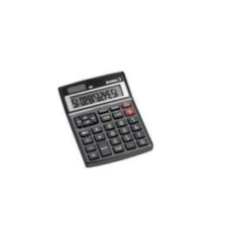

In [8]:
tmp_dataset[random.randint(0,tmp_len-1)][0]

In [9]:
src_transforms = transforms.Compose([
    transforms.Resize(256),
#     transforms.CenterCrop(227),
#     transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(227, scale=(0.50,1.0), ratio=(1.,1.)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[1.,1.,1.]),
    transforms.Lambda(lambda x: torch.stack([x[2],x[1],x[0]])), # RGB -> BGR
    transforms.Lambda(lambda x: x * 255.)
])
tar_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
#     transforms.RandomResizedCrop(224, scale=(0.25,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[1.,1.,1.]),
    transforms.Lambda(lambda x: torch.stack([x[2],x[1],x[0]])),
    transforms.Lambda(lambda x: x * 255.)
])

In [10]:
src_dataset = datasets.ImageFolder(src, transform=src_transforms)
tar_dataset = datasets.ImageFolder(tar, transform=tar_transforms)
srcSampler = torch.utils.data.sampler.RandomSampler(src_dataset)
tarSampler = torch.utils.data.sampler.RandomSampler(tar_dataset)
srcDataLen = len(src_dataset)
tarDataLen = len(tar_dataset)
use_gpu = True and torch.cuda.is_available()

In [11]:
opt = {
    'src': 'Amazon',
    'tar': 'Webcam',
    'manual_seed':1,
    'batchSize':64,
    'use_gpu': use_gpu,
    'num_classes': 31,
    'epochs': 250,
    'momentum': 0.9,
    'lr': 2e-4,
    'lr_sch': 0,
    'lr_sch_gamma': 0.1,
    'p_lr_decay': 250,
    'n0': 1.,
    'alpha': 10,
    'beta': 0.75,
    'betas': (0.5,0.99),
    'net_wtDcy': 0.001,
    'btl_wtDcy': 0.001,
    'srcDataLen': srcDataLen,
    'tarDataLen': tarDataLen
}

experiment.log_multiple_params(opt)

In [12]:
torch.manual_seed(opt['manual_seed'])
if opt['use_gpu']: torch.cuda.manual_seed(opt['manual_seed'])

In [13]:
print("use_gpu: ", opt['use_gpu'])

use_gpu:  True


In [14]:
src_dataloader = torch.utils.data.DataLoader(src_dataset, batch_size=opt['batchSize'], 
                                             shuffle=(srcSampler is None), sampler=srcSampler,
                                            num_workers=2, pin_memory=True, drop_last=False)
tar_dataloader = torch.utils.data.DataLoader(tar_dataset, batch_size=opt['batchSize'],
                                            shuffle=(tarSampler is None), sampler=tarSampler,
                                            num_workers=2, pin_memory=True, drop_last=False)

In [15]:
def init_weights(m):
#     print(m)
    if isinstance(m, nn.Linear):
        init.xavier_normal(m.weight)
        init.constant(m.bias, 0.1)

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(4096,256),
                                       nn.ReLU(inplace=True), nn.Linear(256, opt['num_classes']))
        self.classifier.apply(init_weights)
    
    def forward(self, x):
        x = self.classifier(x)
        return x

In [17]:
net2 = Model()

In [18]:
if opt['use_gpu']:
    net = net.cuda()
    net2 = net2.cuda()
    torch.backends.cudnn.enabled=True
    torch.backends.cudnn.benchmark=True

To computer norm of various parameters

```python
for name, param in net2.named_parameters():
    nrm = torch.norm(param, 2)
    zero = param.eq(0.).float().sum()
    nele = torch.numel(param)
    print(name, nrm.data[0], nele, zero.data[0])
```

In [19]:
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

In [20]:
netfeatwt, netfeatbias = list(), list()
for name, param in net.named_parameters():
    if name in ['10.weight', '12.weight', '16.1.weight', '19.1.weight']: netfeatwt.append(param)
    elif name in ['10.bias', '12.bias', '16.1.bias', '19.1.bias']: netfeatbias.append(param)
    else: param.requires_grad=False

In [21]:
for name, param in net.named_parameters():
    print(name, param.requires_grad)

0.weight False
0.bias False
4.weight False
4.bias False
8.weight False
8.bias False
10.weight True
10.bias True
12.weight True
12.bias True
16.1.weight True
16.1.bias True
19.1.weight True
19.1.bias True


In [22]:
net2_weight, net2_bias = list(), list()
for name, param in net2.named_parameters():
    if 'weight' in name: net2_weight.append(param)
    elif 'bias' in name: net2_bias.append(param)

In [23]:
sgd_params = [
    {'params': netfeatwt, 'lr': opt['lr'], 'momentum': opt['momentum'], 'weight_decay': opt['net_wtDcy'], 'lr_mul': 1., 'name': 'netfeatwt'},
    {'params': netfeatbias, 'lr': opt['lr'], 'momentum': opt['momentum'], 'weight_decay': 0*opt['net_wtDcy'], 'lr_mul': 2., 'name': 'netfeatbias'},
    {'params': net2_weight, 'lr': opt['lr'], 'momentum': opt['momentum'], 'weight_decay': opt['btl_wtDcy'], 'lr_mul': 10., 'name': 'net2wt'},
    {'params': net2_bias, 'lr': opt['lr'], 'momentum': opt['momentum'], 'weight_decay': 0*opt['btl_wtDcy'], 'lr_mul': 20., 'name': 'net2bias'}
]

# optimizer = optim.Adam(net2.parameters(), lr=opt['lr'], betas=opt['betas'], weight_decay=opt['weight_decay'])
# optimizer = optim.Adam(sgd_params, betas=opt['betas'])

optimizer_2 = optim.SGD(sgd_params)
# optimizer_2 = optim.SGD(net2.parameters(), lr=opt['lr'], momentum=opt['momentum'], weight_decay=opt['btl_wtDcy'])

lr_sch = None
if opt['lr_sch']=='step': lr_sch = optim.lr_scheduler.StepLR(optimizer, 20, opt['lr_sch_gamma'])
if opt['lr_sch']=='exponential': lr_sch = optim.lr_scheduler.ExponentialLR(optimizer_2, opt['lr_sch_gamma'])

In [24]:
def get_validation_acc(cm=False):
    tarData = iter(tar_dataloader)
    totalCorrects = 0.
    if cm: y_preds, y_true = list(), list()
    for tarimgs, tarlbls in tarData:
        tarimgs = tarimgs.cuda() if opt['use_gpu'] else tarimgs
        tarlbls = tarlbls.cuda() if opt['use_gpu'] else tarlbls      
        tarimgs = Variable(tarimgs, volatile=True)

        feat_ = net(tarimgs)
        logits = net2(feat_)

        _, preds = torch.max(softmax(logits).data, 1)
        totalCorrects += torch.eq(preds, tarlbls).float().sum()
        if cm: y_preds.append(preds.cpu().numpy()), y_true.append(tarlbls.cpu().numpy())
    valAcc = totalCorrects / opt['tarDataLen']
    if cm: return valAcc, y_preds, y_true
    return valAcc

In [25]:
p = np.linspace(float(1./opt['p_lr_decay']),1,opt['p_lr_decay'])

for epoch in range(opt['epochs']):
    srcData = iter(src_dataloader)
    totalCorrects = 0.
    totalClsLoss = 0.
#     experiment.log_current_epoch(epoch)
    
    n_p = opt['n0'] / pow((1. + opt['alpha'] * p[epoch]), (opt['beta']))
    print("n_p: ", n_p)
    for param_group in optimizer_2.param_groups:
        param_group['lr'] = opt['lr'] * param_group['lr_mul'] * n_p
        
    for srcimgs, srclbls in srcData:
        srcimgs = srcimgs.cuda() if opt['use_gpu'] else srcimgs
        srclbls = srclbls.cuda() if opt['use_gpu'] else srclbls
        srcimgs, srclbls = Variable(srcimgs), Variable(srclbls)
        
        feat_ = net(srcimgs)
        logits = net2(feat_)
        
        clsloss = criterion(logits, srclbls)
        totalClsLoss += clsloss.data[0] * opt['batchSize']
        
        _, preds = torch.max(softmax(logits).data, 1)
        totalCorrects += torch.eq(preds, srclbls.data).float().sum()
               
        optimizer_2.zero_grad()
        clsloss.backward()
        optimizer_2.step()
        
        if lr_sch: lr_sch.step()
        
    srcAcc = totalCorrects / opt['srcDataLen']
    srcLoss = totalClsLoss / opt['srcDataLen']
    valAcc = get_validation_acc()
#     experiment.log_metric("src_clsLoss", srcLoss, step=epoch)
#     experiment.log_metric("src_clsAcc", srcAcc, step=epoch)
#     experiment.log_metric('val_accuracy', valAcc, step=epoch)
#     experiment.log_epoch_end(epoch)
    print("Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, validation acc: {:.4f}".
          format(epoch+1, srcLoss, srcAcc, valAcc))

n_p:  0.971012890912
Epoch: 1, train loss: 2.8401, train acc: 0.3536, validation acc: 0.4239
n_p:  0.94391346936
Epoch: 2, train loss: 1.3085, train acc: 0.6383, validation acc: 0.4541
n_p:  0.918515486359
Epoch: 3, train loss: 1.1293, train acc: 0.6894, validation acc: 0.4843
n_p:  0.894656884184
Epoch: 4, train loss: 0.8999, train acc: 0.7501, validation acc: 0.4818
n_p:  0.872195949493
Epoch: 5, train loss: 0.8293, train acc: 0.7668, validation acc: 0.5031
n_p:  0.851008182997
Epoch: 6, train loss: 0.7816, train acc: 0.7849, validation acc: 0.5057
n_p:  0.830983733898
Epoch: 7, train loss: 0.6973, train acc: 0.7987, validation acc: 0.5069
n_p:  0.812025283127
Epoch: 8, train loss: 0.5958, train acc: 0.8271, validation acc: 0.5157
n_p:  0.794046285931
Epoch: 9, train loss: 0.5129, train acc: 0.8477, validation acc: 0.5019
n_p:  0.776969504241
Epoch: 10, train loss: 0.5115, train acc: 0.8463, validation acc: 0.4994
n_p:  0.760725774313
Epoch: 11, train loss: 0.4771, train acc: 0.8537,

n_p:  0.320461873978
Epoch: 89, train loss: 0.0591, train acc: 0.9819, validation acc: 0.5761
n_p:  0.318369625258
Epoch: 90, train loss: 0.0765, train acc: 0.9783, validation acc: 0.5384
n_p:  0.316308974821
Epoch: 91, train loss: 0.0873, train acc: 0.9730, validation acc: 0.5522
n_p:  0.314279179173
Epoch: 92, train loss: 0.0719, train acc: 0.9776, validation acc: 0.5623
n_p:  0.312279518475
Epoch: 93, train loss: 0.0684, train acc: 0.9766, validation acc: 0.5686
n_p:  0.310309295593
Epoch: 94, train loss: 0.0659, train acc: 0.9791, validation acc: 0.5509
n_p:  0.308367835205
Epoch: 95, train loss: 0.0556, train acc: 0.9844, validation acc: 0.5497
n_p:  0.306454482938
Epoch: 96, train loss: 0.0657, train acc: 0.9812, validation acc: 0.5547
n_p:  0.304568604553
Epoch: 97, train loss: 0.0607, train acc: 0.9805, validation acc: 0.5786
n_p:  0.30270958517
Epoch: 98, train loss: 0.0636, train acc: 0.9787, validation acc: 0.5484
n_p:  0.300876828521
Epoch: 99, train loss: 0.0639, train acc

n_p:  0.209439196679
Epoch: 176, train loss: 0.0452, train acc: 0.9883, validation acc: 0.5673
n_p:  0.208661093703
Epoch: 177, train loss: 0.0394, train acc: 0.9869, validation acc: 0.5623
n_p:  0.207889702654
Epoch: 178, train loss: 0.0368, train acc: 0.9922, validation acc: 0.5597
n_p:  0.207124932996
Epoch: 179, train loss: 0.0502, train acc: 0.9830, validation acc: 0.5547
n_p:  0.206366695852
Epoch: 180, train loss: 0.0405, train acc: 0.9876, validation acc: 0.5635
n_p:  0.205614903962
Epoch: 181, train loss: 0.0477, train acc: 0.9865, validation acc: 0.5623
n_p:  0.20486947165
Epoch: 182, train loss: 0.0355, train acc: 0.9901, validation acc: 0.5560
n_p:  0.204130314783
Epoch: 183, train loss: 0.0439, train acc: 0.9876, validation acc: 0.5358
n_p:  0.203397350741
Epoch: 184, train loss: 0.0404, train acc: 0.9865, validation acc: 0.5522
n_p:  0.202670498379
Epoch: 185, train loss: 0.0712, train acc: 0.9876, validation acc: 0.5786
n_p:  0.201949677994
Epoch: 186, train loss: 0.0889

```
valAcc, y_preds, y_true = get_validation_acc(cm=True)

y_preds = [d for sublist in y_preds for d in sublist]
y_true = [d for sublist in y_true for d in sublist]

cm = confusion_matrix(y_true, y_preds)

np.set_printoptions(precision=2)
plt.figure(figsize=(20,20))
utils.plot_confusion_matrix(cm, classes=src_dataset.classes, normalize=False)
plt.show()
```